## Initialization

In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))
import torch
from kan_hnn import KANHNN
from data import get_dataset

## Help Functions

In [2]:
# print squared loss at specific steps for comparison with HNN
print_every = 200
def print_results(results, print_every=200):
    for step in range(0, len(results["train_loss"]), print_every):
        print(
            "step {}, train_loss {:.4e}, test_loss {:.4e}".format(
                step,
                results["train_loss"][step],
                results["test_loss"][step],
            )
        )

## Create Dataset

In [3]:
# create dataset
THIS_DIR = os.path.dirname(os.path.abspath(os.path.join(".")))
data = get_dataset("2body", THIS_DIR, verbose=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.tensor(data["coords"], requires_grad=True, dtype=torch.float32).to(device)
test_x = torch.tensor(data["test_coords"], requires_grad=True, dtype=torch.float32).to(
    device
)
dxdt = torch.Tensor(data["dcoords"]).to(device)
test_dxdt = torch.Tensor(data["test_dcoords"]).to(device)

# dataset['train_input'], dataset['train_label'],dataset['test_input'], dataset['test_label']
dataset = {
    "train_input": x,
    "train_label": dxdt,
    "test_input": test_x,
    "test_label": test_dxdt,
}

Successfully loaded data from /Users/ZongyuWu/hamiltonian-nn/2body-orbits-dataset.pkl


In [4]:
dataset["train_input"].shape, dataset["train_label"].shape

(torch.Size([40000, 8]), torch.Size([40000, 8]))

## Model Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# initialize KAN with G=3
model = KANHNN(input_dim=2*4, width=[2*4, 5, 3, 2], grid=3, k=3, seed=42, device=device)
results = model.fit(dataset, opt="LBFGS", steps=1000, log=1)
print_results(results, 10)

cpu
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                         | 0/1000 [00:00<?, ?it/s]

| train_loss: 3.59e-06 | test_loss: 3.18e-06 | reg: 9.69e+00 | : 100%|█| 1000/1000 [11:33:04<00:00, 

saving model version 0.1
step 0, train_loss 1.2453e-02, test_loss 1.2357e-02
step 10, train_loss 1.1816e-03, test_loss 9.5067e-04
step 20, train_loss 3.0826e-04, test_loss 2.6551e-04
step 30, train_loss 1.4459e-04, test_loss 1.1516e-04
step 40, train_loss 1.1324e-04, test_loss 9.2079e-05
step 50, train_loss 8.9644e-05, test_loss 7.0379e-05
step 60, train_loss 6.2950e-05, test_loss 5.0972e-05
step 70, train_loss 5.1139e-05, test_loss 4.1830e-05
step 80, train_loss 4.5322e-05, test_loss 3.6280e-05
step 90, train_loss 4.1166e-05, test_loss 3.2067e-05
step 100, train_loss 3.7175e-05, test_loss 2.9236e-05
step 110, train_loss 3.4928e-05, test_loss 2.8089e-05
step 120, train_loss 3.2803e-05, test_loss 2.6480e-05
step 130, train_loss 2.9029e-05, test_loss 2.3872e-05
step 140, train_loss 2.4400e-05, test_loss 2.0021e-05
step 150, train_loss 2.0848e-05, test_loss 1.7050e-05
step 160, train_loss 1.9179e-05, test_loss 1.5913e-05
step 170, train_loss 1.8286e-05, test_loss 1.5002e-05
step 180, trai

In [12]:
# initialize KAN with G=3
model = KANHNN(
    input_dim=2 * 4, width=[2 * 4, 5, 3, 2], grid=3, k=3, seed=42, device=device
)
results = model.fit(dataset, opt="LBFGS", steps=2000, log=1)
print_results(results, 10)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.20e-06 | test_loss: 1.93e-06 | reg: 9.38e+00 | : 100%|█| 2000/2000 [4:41:10<00:00,  

saving model version 0.1
step 0, train_loss 1.2453e-02, test_loss 1.2357e-02
step 10, train_loss 1.1816e-03, test_loss 9.5067e-04
step 20, train_loss 3.0826e-04, test_loss 2.6551e-04
step 30, train_loss 1.4459e-04, test_loss 1.1516e-04
step 40, train_loss 1.1324e-04, test_loss 9.2079e-05
step 50, train_loss 8.9644e-05, test_loss 7.0379e-05
step 60, train_loss 6.2950e-05, test_loss 5.0972e-05
step 70, train_loss 5.1139e-05, test_loss 4.1830e-05
step 80, train_loss 4.5322e-05, test_loss 3.6280e-05
step 90, train_loss 4.1166e-05, test_loss 3.2067e-05
step 100, train_loss 3.7175e-05, test_loss 2.9236e-05
step 110, train_loss 3.4928e-05, test_loss 2.8089e-05
step 120, train_loss 3.2803e-05, test_loss 2.6480e-05
step 130, train_loss 2.9029e-05, test_loss 2.3872e-05
step 140, train_loss 2.4400e-05, test_loss 2.0021e-05
step 150, train_loss 2.0848e-05, test_loss 1.7050e-05
step 160, train_loss 1.9179e-05, test_loss 1.5913e-05
step 170, train_loss 1.8286e-05, test_loss 1.5002e-05
step 180, trai

[tensor([2.4930, 2.4828, 3.5366, 3.5904, 0.6948, 0.6925, 0.8088, 0.8013],
       grad_fn=<MeanBackward1>), tensor([0.7664, 0.8481, 0.4169, 0.5667, 1.4286], grad_fn=<MeanBackward1>), tensor([0.6707, 0.3141, 0.5852], grad_fn=<MeanBackward1>), tensor([0.5000, 0.5000], grad_fn=<MeanBackward1>)]


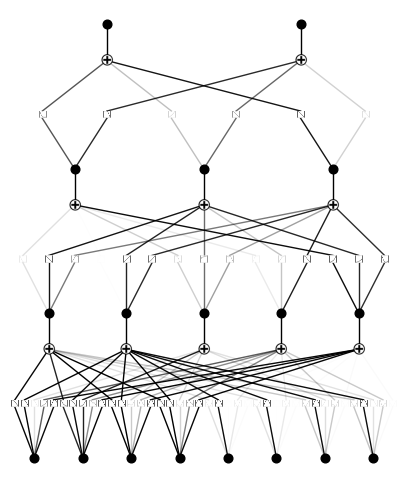

In [13]:
model.attribute()
print(model.node_scores)
model.plot()

saving model version 0.2


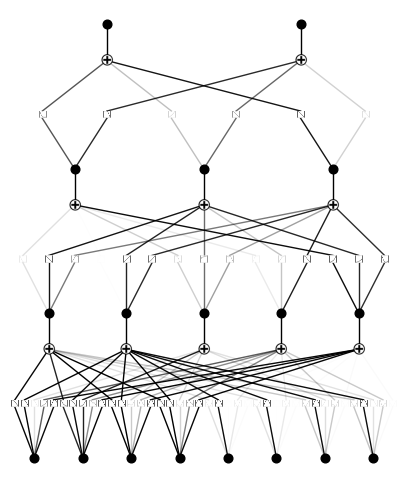

In [14]:
model = model.prune_node(threshold=1e-1)
model.plot()

In [15]:
mode = "auto"  # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0, 0, 0, "x^2")
    model.fix_symbolic(0, 1, 0, "x^2")
    model.fix_symbolic(1, 0, 0, "x")
    model.fix_symbolic(1, 0, 1, "x")
elif mode == "auto":
    # automatic mode
    lib = ["x", "x^2", "x^3", "x^4", "sqrt", "tanh", "sin", "abs", '1/x']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9994704723358154, c=2
fixing (0,0,1) with sin, r2=0.9980565309524536, c=2
fixing (0,0,2) with sin, r2=0.9985499382019043, c=2
fixing (0,0,3) with x, r2=0.9185046553611755, c=1
fixing (0,0,4) with sin, r2=0.9949221014976501, c=2
fixing (0,1,0) with x^2, r2=0.9956206679344177, c=2
fixing (0,1,1) with x, r2=0.987770676612854, c=1
fixing (0,1,2) with sin, r2=0.9994062781333923, c=2
fixing (0,1,3) with x, r2=0.8217699527740479, c=1
fixing (0,1,4) with sin, r2=0.9866481423377991, c=2
fixing (0,2,0) with sin, r2=0.9998152852058411, c=2
fixing (0,2,1) with sin, r2=0.9999172687530518, c=2
fixing (0,2,2) with x, r2=0.334659218788147, c=1
fixing (0,2,3) with sin, r2=0.9416592717170715, c=2
fixing (0,2,4) with sin, r2=0.9926812648773193, c=2
fixing (0,3,0) with x^2, r2=0.9983758926391602, c=2
fixing (0,3,1) with sin, r2=0.9994068741798401, c=2
fixing (0,3,2) with x^2, r2=0.9777528643608093, c=2
fixing (0,3,3) with x, r2=0.35896027088165283, c=1
fixing (0,3,4) with sin

In [ ]:
from kan.utils import ex_round

[ex_round(y, 4) for y in model.symbolic_formula()[0]]

[-0.0255*(x_1 + 0.0005)**2 - 0.0258*(x_2 - 0.0056)**2 - 0.0127,
 0.9815*(x_1 + 0.0005)**2 + 0.9925*(x_2 - 0.0056)**2 - 0.8103]

![hnn](./hnn.png)
![baseline](./baseline.png)
